0=women
1=men
0=no pd
1=pd

In [1]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

**`Read data and Display data dimension`**

In [2]:
pd_speech_features = pd.read_csv('pd_speech_features.csv')
new_header = pd_speech_features.iloc[0] #grab the first row for the header
pd_speech_features = pd_speech_features[1:] #take the data less the header row
pd_speech_features.columns = new_header #set the header row as the df header
pd_speech_features.head()
print('The shape of the matrix is :', pd_speech_features.shape)

The shape of the matrix is : (756, 755)


In [3]:
pd_speech_features['class']

1      1
2      1
3      1
4      1
5      1
      ..
752    0
753    0
754    0
755    0
756    0
Name: class, Length: 756, dtype: object

#### Gather most general metadata about the data

In [4]:
pd_speech_features['patient/healthy count'] = 1
pd_speech_features.groupby('class').sum()/3

,patient/healthy count
class,
0,64.0
1,188.0


In [5]:
#pd_speech_features['patient/healthy count'] = 1
pd_speech_features['gender'].value_counts()

1    390
0    366
Name: gender, dtype: int64

In [6]:
pd_speech_features[['gender','class']]=pd_speech_features[['gender','class']].astype('int')
pd_speech_features.groupby(by='gender')['class'].sum()/3

gender
0     81.0
1    107.0
Name: class, dtype: float64

In [7]:
pd_speech_features = pd_speech_features.drop(['patient/healthy count'], axis = 1)  #756x755

All the data was imported in the object type, we now need to take care about the types in the dataframe

In [8]:
pd_speech_features =  pd_speech_features.astype(float) #per default all floats 
pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']] = pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']].astype(int) #ints
pd_speech_features[['gender', 'class']] = pd_speech_features[['gender', 'class']].astype('category') #categoricals
pd_speech_features.dtypes

0
id                              int32
gender                       category
PPE                           float64
DFA                           float64
RPDE                          float64
                               ...   
tqwt_kurtosisValue_dec_33     float64
tqwt_kurtosisValue_dec_34     float64
tqwt_kurtosisValue_dec_35     float64
tqwt_kurtosisValue_dec_36     float64
class                        category
Length: 755, dtype: object

In [9]:
df=pd_speech_features

In [10]:
class Htest:
    def __init__(self, population_mean_diff=0, p=0.05, cls_names='class', test_type='z_test'):
        
        '''
            cls_vals=target class values
            p=confidence interval, default=0.05
            
            population_mean_diff: 
                        H0(null hypothesis): difference of population mean over feature F, default=0
            
            cls_names=sample classes
            
            test_type: what kind of hypothesis testing
                            
        '''
        
        self.p=p
        self.cls=cls_names
        self.population_mean_diff=population_mean_diff
        
    def z_test(self, df1, df2, threshold_val=1.96, show_top=1):
        '''
        Assumptions:
                    1. sample size=population size
                    2. normal distribution
        input:
                df1=dataframe of numerical features of sample1
                df2=dataframe of numerical features of sample2
                threshold_val= z score of 1.96 for 95% confidence(p<0.05)
        '''
        self.df1=df1
        self.df2=df2
        
        std_error1=(self.df1.std().pow(2.))/self.df1.shape[0]
        std_error2=(self.df2.std().pow(2.))/self.df2.shape[0]
        
        denominator=(std_error1+std_error2).pow(1./2)
        
        nominator=(self.df1.mean()-self.df2.mean())\
                    -self.population_mean_diff
        
        z_scores=nominator/denominator
        feature_z=z_scores[z_scores.abs()>threshold_val].abs()
        
        return feature_z
        

In [11]:
htest=Htest()

In [12]:
dfk=df.kurtosis().between(-1,1) 
dfs=df.skew().between(-1,1, inclusive=True)

normals=set(dfk.index)-(set(dfk.index)-set(dfs.index))
print(len(normals))

753


C:\Users\User\AppData\Local\Temp/ipykernel_15436/360618407.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfk=df.kurtosis().between(-1,1)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/360618407.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfs=df.skew().between(-1,1, inclusive=True)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/360618407.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  dfs=df.skew().between(-1,1, inclusive=True)


In [13]:
def sk(df):
    dfk=df.kurtosis().between(-1,1) 
    dfs=df.skew().between(-1,1, inclusive=True)
    
    ktrue=[]
    strue=[]
    
    for i,j in zip(dfs.index,dfs.values): 
        if j==True:
            #print(i,' ',j)
            strue.append(i)
    
    print('skewness:',len(strue))
    
    for i,j in zip(dfk.index,dfk.values): 
        if j==True:
            #print(i,' ',j)
            ktrue.append(i)
    
    print('kurtosis:',len(ktrue))
    
    return set(strue),set(ktrue)

In [14]:
sn,kn=sk(df)
fns=sn.intersection(kn)
print(len(fns))

skewness: 227
kurtosis: 151
147


C:\Users\User\AppData\Local\Temp/ipykernel_15436/3755790733.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfk=df.kurtosis().between(-1,1)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/3755790733.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfs=df.skew().between(-1,1, inclusive=True)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/3755790733.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  dfs=df.skew().between(-1,1, inclusive=True)


In [95]:
fns=list(fns)

if 'gender' not in fns:
    fns.append('gender')
    
if 'class' not in fns:
    fns.append('class')


dfn=df.loc[:,fns]
print(dfn.shape)
dfn=dfn[dfn['class']==1]
print(dfn.shape)

(756, 149)
(564, 149)


In [96]:
len(fns)

149

Till now df means all data<br>
Till now dfn means Pd positive data

In [100]:
df1=dfn[(dfn['gender']==0) & (dfn['class']==1)].drop(['gender','class'],axis=1)
df2=dfn[(dfn['gender']==1) & (dfn['class']==1)].drop(['gender','class'],axis=1)

In [101]:
fg=htest.z_test(df1,df2)

In [102]:
fg.shape

(70,)

In [103]:
gender_df_all=df[df['class']==1]

Till now gender_df means data of PD positive patients

In [104]:
gender_features=list(fg.index)
print('statistically significant features based on gender: ', len(gender_features))
gender_features.append('gender')# will perform unsupervised learning

statistically significant features based on gender:  70


In [105]:
dfn.shape

(564, 149)

In [106]:
gender_df=dfn[gender_features]

In [75]:
gender_df.shape

(564, 71)

We are plotting these tsne graphs for PD positive patients.<br>
gender_df are PD positive patients with Fg(70 selected features from the hypothesis test)

In [107]:
def plot_tsne(df, p=30, n_components=2):
    
    train_df=df.values
    x_train=train_df[:,:-1]
    y_train=train_df[:,-1]
    print('x_train shape: ', x_train.shape)
    sc=StandardScaler()
    x_train=sc.fit_transform(x_train)
    
    tsne = TSNE(n_components=n_components,perplexity=p,n_iter=1000,init='pca', random_state=10)

    X_tsne = tsne.fit_transform(x_train)
    print(X_tsne.shape)
    plt.figure(figsize=(7,6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, 
            edgecolor='none', alpha=0.8, s=20,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
    plt.colorbar()
    title='perplexity='+str(p)
    figname='gender_20_feature_cluster_perplexity='+str(p)
    plt.title(title)
    plt.savefig(figname)
    #1500,20,pca
    #3000,7,pca
    #3000,8,PCA

x_train shape:  (564, 70)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(564, 2)


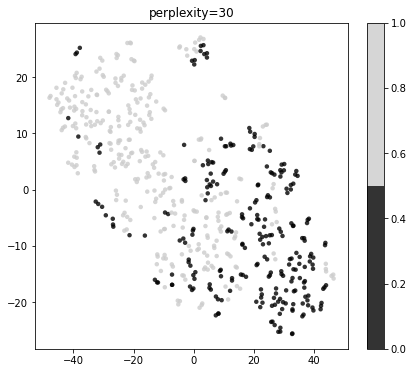

In [108]:
plot_tsne(gender_df,p=30)

755
x_train shape:  (564, 754)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(564, 2)


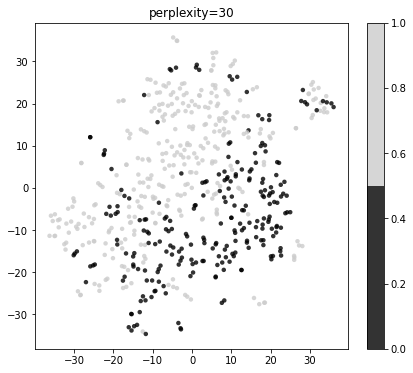

In [110]:
all_features=list(df.columns)
all_features.remove('gender')
#all_features.remove('class')
all_features.append('gender')#removing from data, then adding in the last column
print(len(all_features))
df_only_positive=df[df['class']==1]
df_only_positive_all_features=df_only_positive[all_features]
df_only_positive_all_features.head()

plot_tsne(df_only_positive_all_features, p=30)

In [111]:
df.shape

(756, 755)

In [112]:
fg.index

Index(['tqwt_entropy_log_dec_10', 'std_9th_delta_delta', 'std_6th_delta_delta',
       'app_LT_TKEO_std_3_coef', 'mean_MFCC_9th_coef',
       'app_LT_entropy_shannon_10_coef', 'app_LT_entropy_shannon_8_coef',
       'app_entropy_log_10_coef', 'GNE_SNR_SEO', 'tqwt_entropy_log_dec_26',
       'app_LT_TKEO_mean_8_coef', 'app_LT_TKEO_std_8_coef',
       'app_LT_entropy_shannon_6_coef', 'mean_MFCC_4th_coef',
       'app_LT_entropy_shannon_7_coef', 'tqwt_entropy_log_dec_11',
       'app_LT_entropy_shannon_3_coef', 'app_LT_TKEO_std_6_coef',
       'tqwt_energy_dec_18', 'det_entropy_log_9_coef', 'tqwt_energy_dec_17',
       'meanPeriodPulses', 'app_LT_entropy_shannon_5_coef',
       'app_LT_TKEO_std_5_coef', 'app_LT_TKEO_mean_5_coef',
       'mean_MFCC_7th_coef', 'app_entropy_log_9_coef',
       'app_LT_TKEO_mean_10_coef', 'std_12th_delta_delta',
       'app_LT_entropy_log_10_coef', 'tqwt_entropy_log_dec_13',
       'app_LT_entropy_shannon_2_coef', 'tqwt_minValue_dec_18',
       'tqwt_entropy_

In [18]:
#skipping over a lot of code earlier
fns=list(fns)
len(fns)

147

Finding out which group our features belong to

In [19]:
d={'baseline':21,'time_frequency':11,'mfccs':84,'wavelet_transform':182,'vocal_fold':22,'tqwt':432}

baseline=[]
time_frequency=[]
mfccs=[]
wavelet_transform=[]
vocal_fold=[]
tqwt=[]

all_features=list(df.columns)[2:]#basically removing Id and gender from the feature consideration
#selected_features_for_genders=list(fg.index)
selected_features_FH=fns

def check_which(g_features, all_features):
    
    d={'baseline':0,'time_frequency':0,'mfccs':0,'wavelet_transform':0,'vocal_fold':0,'tqwt':0}
    
    for i in g_features:
        idx=all_features.index(i)
        
        if idx<21:
            d['baseline']+=1
            baseline.append(i)
        elif idx>=21 and idx<32:
            d['time_frequency']+=1
            time_frequency.append(i)
        elif idx>=32 and idx<116:
            d['mfccs']+=1
            mfccs.append(i)
        elif idx>=116 and idx<298:
            d['wavelet_transform']+=1
            wavelet_transform.append(i)
        elif idx>=298 and idx<320:
            d['vocal_fold']+=1
            vocal_fold.append(i)
        elif idx>-320 and idx<752:
            d['tqwt']+=1
            tqwt.append(i)
        else:
            print('check function again.')
    
    return d

check_which(selected_features_FH, all_features)

{'baseline': 4,
 'time_frequency': 4,
 'mfccs': 21,
 'wavelet_transform': 30,
 'vocal_fold': 18,
 'tqwt': 70}

In [20]:
print(df.shape)

(756, 755)


In [21]:
print('baseline',baseline)
print('time_freqeuncey', time_frequency)
print('mfccs', mfccs)
print('wavelet transform', wavelet_transform)
print('vocal fold', vocal_fold)
print('tqwt', tqwt)

FH_baseline=df[baseline]
FH_baseline.to_csv('FH_baseline.csv', index=False)
FH_time_frequency=df[time_frequency]
FH_time_frequency.to_csv('FH_time_frequency.csv', index=False)
FH_mfccs=df[mfccs]
FH_mfccs.to_csv('FH_mfccs.csv', index=False)
FH_wavelet_transform=df[wavelet_transform]
FH_wavelet_transform.to_csv('FH_wavelet_transform.csv', index=False)
FH_vocal_fold=df[vocal_fold]
FH_vocal_fold.to_csv('FH_vocal_fold.csv', index=False)
FH_tqwt=df[tqwt]
FH_tqwt.to_csv('FH_tqwt.csv', index=False)
FH_concat=df[baseline+vocal_fold+time_frequency]
FH_concat.to_csv('FH_concat.csv', index=False)
df['class'].to_csv('class.csv', index=False)

baseline ['RPDE', 'DFA', 'meanPeriodPulses', 'meanHarmToNoiseHarmonicity']
time_freqeuncey ['f3', 'f2', 'f1', 'f4']
mfccs ['std_MFCC_10th_coef', 'mean_8th_delta_delta', 'mean_MFCC_5th_coef', 'mean_MFCC_7th_coef', 'VFER_NSR_SEO', 'GNE_SNR_SEO', 'mean_MFCC_10th_coef', 'mean_MFCC_6th_coef', 'mean_MFCC_8th_coef', 'IMF_NSR_entropy', 'VFER_NSR_TKEO', 'mean_MFCC_4th_coef', 'mean_MFCC_1st_coef', 'mean_MFCC_3rd_coef', 'mean_MFCC_9th_coef', 'mean_MFCC_2nd_coef', 'mean_12th_delta_delta', 'mean_MFCC_12th_coef', 'std_MFCC_9th_coef', 'mean_MFCC_11th_coef', 'mean_11th_delta']
wavelet transform ['std_12th_delta_delta', 'std_9th_delta', 'std_8th_delta', 'app_LT_entropy_log_8_coef', 'app_LT_entropy_shannon_2_coef', 'std_12th_delta', 'det_LT_entropy_log_10_coef', 'std_10th_delta_delta', 'app_LT_entropy_shannon_3_coef', 'app_LT_entropy_shannon_8_coef', 'det_entropy_log_9_coef', 'app_entropy_log_10_coef', 'std_8th_delta_delta', 'std_9th_delta_delta', 'app_entropy_log_8_coef', 'app_LT_entropy_shannon_5_coef

In [22]:
baseline+wavelet_transform

['RPDE',
 'DFA',
 'meanPeriodPulses',
 'meanHarmToNoiseHarmonicity',
 'std_12th_delta_delta',
 'std_9th_delta',
 'std_8th_delta',
 'app_LT_entropy_log_8_coef',
 'app_LT_entropy_shannon_2_coef',
 'std_12th_delta',
 'det_LT_entropy_log_10_coef',
 'std_10th_delta_delta',
 'app_LT_entropy_shannon_3_coef',
 'app_LT_entropy_shannon_8_coef',
 'det_entropy_log_9_coef',
 'app_entropy_log_10_coef',
 'std_8th_delta_delta',
 'std_9th_delta_delta',
 'app_entropy_log_8_coef',
 'app_LT_entropy_shannon_5_coef',
 'app_LT_entropy_shannon_6_coef',
 'app_LT_entropy_shannon_7_coef',
 'det_entropy_log_8_coef',
 'app_entropy_log_7_coef',
 'app_LT_entropy_shannon_9_coef',
 'det_LT_entropy_log_9_coef',
 'app_entropy_log_6_coef',
 'std_11th_delta_delta',
 'app_LT_entropy_shannon_10_coef',
 'std_10th_delta',
 'app_entropy_log_9_coef',
 'app_LT_entropy_shannon_4_coef',
 'std_6th_delta_delta',
 'det_entropy_log_10_coef']

In [24]:
FH_baseline

,RPDE,DFA,meanPeriodPulses,meanHarmToNoiseHarmonicity
1,0.57227,0.71826,0.008064,18.995
2,0.53966,0.69481,0.008258,21.497
3,0.58982,0.67604,0.008340,17.651
4,0.59257,0.79672,0.010858,19.865
5,0.53028,0.79782,0.008162,19.557
...,...,...,...,...
752,0.28385,0.56355,0.004627,26.813
753,0.59194,0.56499,0.004550,17.802
754,0.46815,0.72335,0.005069,24.005
755,0.49823,0.74890,0.005679,19.706


In [25]:
fns.sort_values(ascending=False).head(50)

AttributeError: 'list' object has no attribute 'sort_values'

In [26]:
len(fns)

147

x_train shape:  (564, 10)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(564, 2)


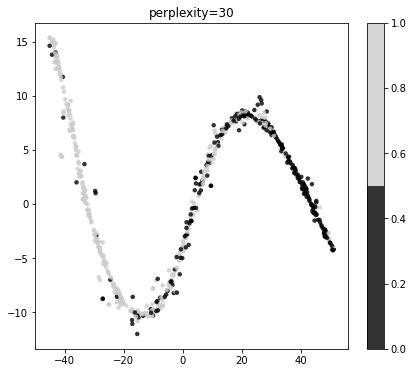

In [126]:
fgsorted=fg.sort_values(ascending=False).head(10)
sorted_features=list(fgsorted.index)
sorted_features.append('gender')
sorted_fg=dfn[sorted_features]
plot_tsne(sorted_fg,30)

x_train shape:  (564, 70)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(564, 2)


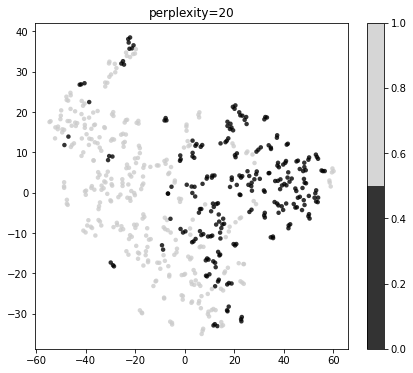

In [128]:
fgsorted=fg.sort_values(ascending=False).head(70)
sorted_features=list(fgsorted.index)
sorted_features.append('gender')
sorted_fg=dfn[sorted_features]
plot_tsne(sorted_fg,20)

In [35]:
pca=PCA(n_components=10)
train_df=gender_df.values
x_train=train_df[:,:-1]
y_train=train_df[:,-1]

pca_result=pca.fit_transform(x_train)

In [36]:
pca_gender=pd.DataFrame(columns=[str(i) for i in range(pca_result.shape[1])])

for i in range(pca_result.shape[1]):
    pca_gender[str(i)]=pca_result[:,i]

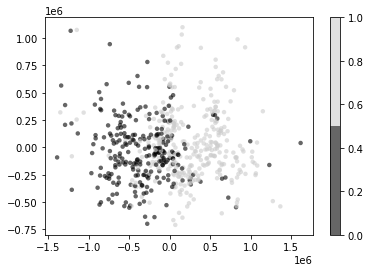

In [37]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train, 
            edgecolor='none', alpha=0.6, s=20,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()

#plt.title(title)

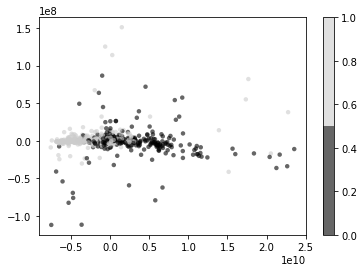

In [38]:
train_df=all_data.values
x_train=train_df[:,:-1]
y_train=train_df[:,-1]

pca_result=pca.fit_transform(x_train)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train, 
            edgecolor='none', alpha=0.6, s=20,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()


In [39]:
def plot_pca_tsne(df, p=30, n_components=2, pca_components=20):
    
    train_df=df.values
    x_train=train_df[:,:-1]
    y_train=train_df[:,-1]
    print('x_train shape: ', x_train.shape)
    sc=StandardScaler()
    x_train=sc.fit_transform(x_train)
    
    pca=PCA(n_components=pca_components)
    pca_result=pca.fit_transform(x_train)
    
    tsne = TSNE(n_components=n_components,perplexity=p,n_iter=3000,init='random', random_state=10)

    X_tsne = tsne.fit_transform(pca_result)
    print(X_tsne.shape)
    plt.figure(figsize=(7,6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, 
            edgecolor='none', alpha=0.8, s=20,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
    plt.colorbar()
    title='perplexity='+str(p)
    figname='gender_cluster_perplexity with pca='+str(p)
    plt.title(title)
    plt.savefig(figname)
    #1500,20,pca
    #3000,7,pca
    #3000,8,PCA

x_train shape:  (564, 70)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(564, 2)


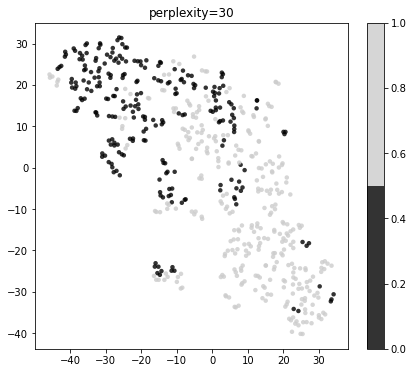

In [40]:
plot_pca_tsne(gender_df, p=30)

x_train shape:  (564, 754)


C:\Users\User\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(564, 2)


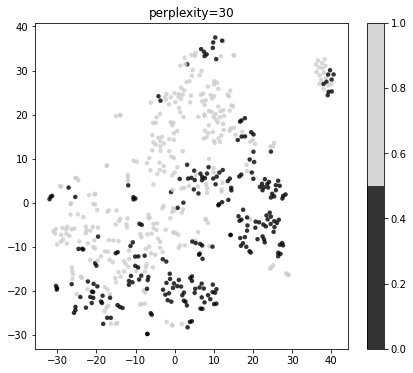

In [41]:
plot_pca_tsne(all_data, p=30)

In [133]:
df['class']

C:\Users\User\.conda\envs\dl\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
752    0.0
753    0.0
754    0.0
755    0.0
756    0.0
Name: class, Length: 756, dtype: category
Categories (2, float64): [0.0, 1.0]

In [1]:
dfn.shape

NameError: name 'dfn' is not defined